In [31]:
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [32]:
# read data
# TO-DO: loop through the different tabs in excel
coronavirus = pd.read_excel('./data/time_series.xlsx', sheet_name='coronavirus', header=[0], index_col=[0])
educacion = pd.read_excel('./data/time_series.xlsx', sheet_name='educacion', header=[0], index_col=[0])
musica = pd.read_excel('./data/time_series.xlsx', sheet_name='musica', header=[0], index_col=[0])
trabajo = pd.read_excel('./data/time_series.xlsx', sheet_name='trabajo', header=[0], index_col=[0])

coronavirus = coronavirus.transpose().reset_index()
coronavirus.columns = ['date','Factiva','GoogleTrends']
coronavirus['topic'] = 'coronavirus'
educacion = educacion.transpose().reset_index()
educacion.columns = ['date','Factiva','GoogleTrends']
educacion['topic'] = 'educacion'
musica = musica.transpose().reset_index()
musica.columns = ['date','Factiva','GoogleTrends']
musica['topic'] = 'musica'
trabajo = trabajo.transpose().reset_index()
trabajo.columns = ['date','Factiva','GoogleTrends']
trabajo['topic'] = 'trabajo'

data = pd.concat([coronavirus,educacion,musica,trabajo],axis=0)
data

,date,Factiva,GoogleTrends,topic
0,2020-01-01,0,0,coronavirus
1,2020-01-02,0,0,coronavirus
2,2020-01-03,0,0,coronavirus
3,2020-01-04,0,4,coronavirus
4,2020-01-05,0,0,coronavirus
...,...,...,...,...
177,2020-06-26,28,0,trabajo
178,2020-06-27,11,0,trabajo
179,2020-06-28,16,0,trabajo
180,2020-06-29,14,10,trabajo


In [33]:
data_melted = data.melt(id_vars=['date','topic'], var_name='source', value_vars=['Factiva','GoogleTrends'])
data_melted

,date,topic,source,value
0,2020-01-01,coronavirus,Factiva,0
1,2020-01-02,coronavirus,Factiva,0
2,2020-01-03,coronavirus,Factiva,0
3,2020-01-04,coronavirus,Factiva,0
4,2020-01-05,coronavirus,Factiva,0
...,...,...,...,...
1451,2020-06-26,trabajo,GoogleTrends,0
1452,2020-06-27,trabajo,GoogleTrends,0
1453,2020-06-28,trabajo,GoogleTrends,0
1454,2020-06-29,trabajo,GoogleTrends,10


In [34]:
topic = 'coronavirus'
g = px.line(data_melted[data_melted.topic==topic], x='date', y='value', color='source')
g.show()

In [35]:
#simple pandas correlations
p_pearson = data[data.topic==topic][['Factiva','GoogleTrends']].corr(method='pearson')
print(p_pearson)
p_spearman = data[data.topic==topic][['Factiva','GoogleTrends']].corr(method='spearman')
print(p_spearman)


               Factiva  GoogleTrends
Factiva       1.000000      0.835567
GoogleTrends  0.835567      1.000000
               Factiva  GoogleTrends
Factiva       1.000000      0.821456
GoogleTrends  0.821456      1.000000


In [36]:
#scipy stats correlation
r, p = stats.pearsonr(data[data.topic==topic]['Factiva'],data[data.topic==topic]['GoogleTrends'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.835567439863106 and p-value: 1.0688783017201935e-48


In [37]:
rolling_median = data[data.topic==topic][['Factiva','GoogleTrends']].rolling(window=7, center=True).median()
rolling_median

,Factiva,GoogleTrends
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,0.0,0.0
4,0.0,3.0
...,...,...
177,458.0,46.0
178,461.0,41.0
179,NaN,NaN
180,NaN,NaN


In [38]:
g = px.line(rolling_median)
g.show()

In [39]:
#Window segmented correlation
#TO DO: 
# Add real index
# compute for all topics in a loop
# function to calculate it all
# investigate how seasonality affects it
# draw topics on separate axis?
# add granger test with lagged 

rolling_window_size = 7
data_interpol = data[data.topic==topic][['Factiva','GoogleTrends']].interpolate()
data_interpol_median = rolling_median[['Factiva','GoogleTrends']].interpolate()

data_rolling = data_interpol['Factiva'].rolling(window=rolling_window_size, center=True).corr(data_interpol['GoogleTrends'])
data_rolling_median = data_interpol_median['Factiva'].rolling(window=rolling_window_size, center=True).corr(data_interpol['GoogleTrends'])
data_rolling

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
177   -0.195707
178   -0.222647
179         NaN
180         NaN
181         NaN
Length: 182, dtype: float64

In [40]:
g = px.line(data_rolling)
g.show()

In [41]:
g = px.line(data_rolling_median)
g.show()

In [63]:
d1 = data[data.topic==topic]['Factiva'].fillna(0)
d2 = data[data.topic==topic]['GoogleTrends'].fillna(0)

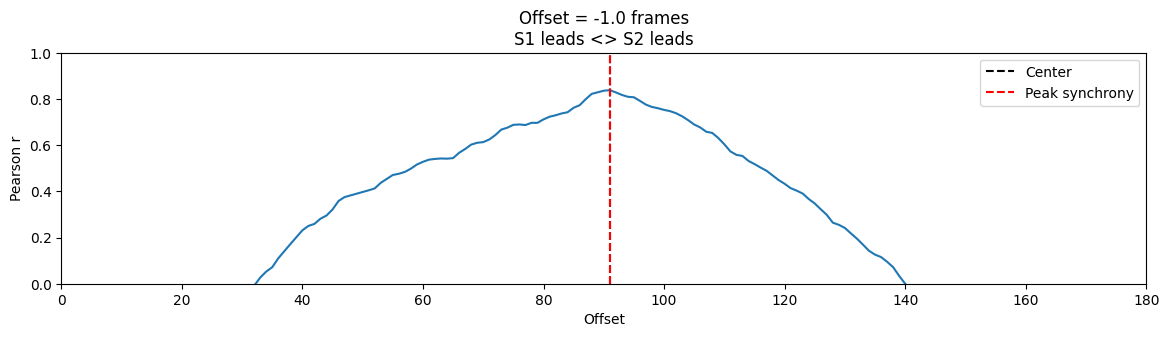

In [64]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

lag_window = 90

rs = [crosscorr(d1,d2, lag) for lag in range(-int(lag_window),int(lag_window+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[0,1],xlim=[0,lag_window*2], xlabel='Offset',ylabel='Pearson r')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

In [75]:
d1 = data[data.topic==topic]['Factiva'].fillna(0)
d2 = data[data.topic==topic]['GoogleTrends'].fillna(0)

In [117]:

# Windowed time lagged cross correlation
lag_window = 7
no_splits = 10
samples_per_split = 18
rss=[]
for t in range(0, no_splits):
    d1w = d1.loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2w = d2.loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1w,d2w, lag) for lag in range(-int(lag_window),int(lag_window+1))]
    rss.append(rs)
rss_wtl = pd.DataFrame(rss).fillna(0)

rss_wtl

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.171802,-0.189675,-0.203465,-0.186107,-0.196813,0.259704,0.410264,-0.157792,-0.168932,0.259704,0.402997,0.245256,-0.236015,0.387258,-0.295540
1,-0.173791,0.006790,-0.153797,-0.109168,0.103252,0.359583,0.486930,0.593640,0.710931,0.573518,0.178649,0.122879,0.152263,-0.025448,-0.246784
2,-0.370142,0.009610,0.083496,0.142383,0.157966,0.075267,-0.173663,0.079360,0.215028,0.025010,0.055438,0.070138,-0.120415,-0.205526,-0.137878
3,0.409770,0.383723,0.013220,0.105100,0.389463,0.692170,0.883764,0.951255,0.914312,0.761738,0.468706,0.074820,-0.005614,-0.097155,0.026565
4,-0.622044,-0.361931,0.004089,0.451365,0.297902,0.115405,-0.349855,-0.502375,-0.168218,0.118986,0.518468,0.325702,0.039749,-0.416884,-0.597784
5,0.297407,0.181508,-0.008369,-0.418846,-0.158130,0.071806,0.181256,0.229529,0.303508,-0.057648,-0.209141,-0.044771,0.216188,0.228000,-0.067952
6,0.140771,-0.050349,-0.065598,-0.299276,-0.544475,-0.430071,-0.374093,-0.195161,-0.293913,-0.263212,-0.017917,-0.161175,-0.156032,-0.081327,-0.362875
7,0.188967,0.016589,0.274570,-0.093132,0.028637,0.073205,0.299672,0.437691,0.107284,0.099845,-0.002041,0.068100,0.242793,0.260308,0.296882
8,0.051895,0.050207,0.251624,0.332532,0.382886,0.442355,0.216277,0.172530,0.131734,0.101874,-0.136295,-0.345645,-0.141378,0.092679,0.051180
9,0.407274,0.119287,-0.072150,-0.259227,0.126077,0.440164,0.563742,0.344722,0.499317,0.318712,0.095753,0.105296,0.445135,0.562737,0.410211


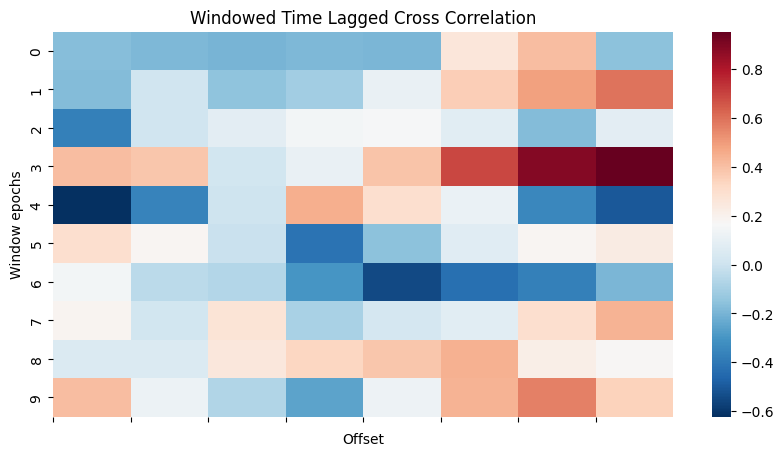

In [118]:
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,lag_window+1], xlabel='Offset',ylabel='Window epochs');
ax.set_xticks(range(0,int(lag_window+1)));
#ax.set_xticklabels(range(-int(lag_window,int(lag_window+1))));

In [ ]:
# Rolling window time lagged cross correlation
window_size = 14 #samples
t_start = 0
t_end = t_start + window_size
step_size = 7
rss=[]
while t_end < 180:
    d1 = data[data.topic==topic]['Factiva'].iloc[t_start:t_end]
    d2 = data[data.topic==topic]['GoogleTrends'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(lag_window),int(lag_window+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss_rwtl = pd.DataFrame(rss)

rss_wtl

#f,ax = plt.subplots(figsize=(10,10))
#sns.heatmap(rss,cmap='RdBu_r',ax=ax)
#ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,lag_window+1], xlabel='Offset',ylabel='Epochs')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);